# Setup

In [50]:
from google.colab import drive
import os

# skip, if not running on Google Colab
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [51]:
# import modules and set options
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import iqr

pd.options.display.max_rows = 100 #default = 60
sns.set_theme(style="whitegrid")

In [52]:
# load csv dataset into DataFrame
df = pd.read_csv('vehicles.csv')

In [53]:
# sneak peek on data
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


# Preliminary Feature selection

- **County** has no values, hence can be removed.
- Features like **image_url**, **url**, **VIN** and **id**, **description** can be removed as well as they don't serve any analytical purpose for this project.
- Redundant features can be removed as well. E.g. **region_url** contains the same information as region
- **Posting_date** will be removed as the conversion from string to a date or unix timestamp format is not feasable with over 400k submissions. We'll make the assumption that the submission date has no relationship with the other features.

In [54]:
df = df.drop(['county', 'image_url', 'url', 'VIN', 'id', 'region_url', 'description', 'posting_date'], axis=1)
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN


# Handling of Missing Values

## A look at the data

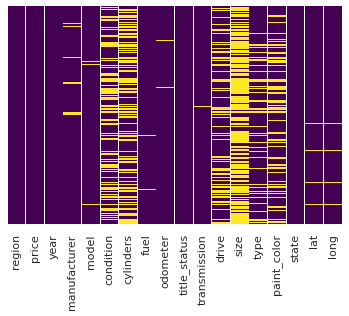

In [ ]:
# recap of missing value heat map
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [ ]:
# calculate percentage of missing values per column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                 'missing_values': df.isnull().sum()}
                                )
missing_value_df.sort_values(['percent_missing'], ascending=False).transpose()

,size,cylinders,condition,drive,paint_color,type,manufacturer,title_status,lat,long,model,odometer,fuel,transmission,year,price,state,region
column_name,size,cylinders,condition,drive,paint_color,type,manufacturer,title_status,lat,long,model,odometer,fuel,transmission,year,price,state,region
percent_missing,71.7675,41.6225,40.7852,30.5863,30.5011,21.7527,4.13371,1.93075,1.53415,1.53415,1.23618,1.03073,0.705819,0.598763,0.282281,0,0,0
missing_values,306361,177678,174104,130567,130203,92858,17646,8242,6549,6549,5277,4400,3013,2556,1205,0,0,0


This dataset contains a lot of missing values, in one feature it even exceeds a quota of 70%!

This confronts us with a dilemma: We either sacrifice a large portion of our data to maintain a complete dataset or we heavily impute/interpolate our dataset to 'fill in the blanks'. The latter option is especially risky when there are a lot of missing values in one column.

The goal should be to strike a balance between both options.

In the previous task we established that the data does seem to be missing at random, excluding VIN, which has been removed anyway. We could statistically check for values completly at random with Little's MCAR test, but as with the datetime conversion, it wouldn't be feasible to do with this large dataset, Also, the MCAR test works best with numerical data, since it's calculated with mean values. Since the majority of missing values are in the categorical features, the MCAR-test probably wouldn't perform very well.

In short, since we didn't implement any MCAR test, we'll proceed with the assumption that values are MCAR (missing completly at random).

## Removing and Imputing missing values

As mentioned above, we need to strike a balance between removing and imputing values. It's not benificial for example to impute features that are missing in a large portion of the data, as the imputed values can heavily skew this feature. At the same time we want to retain as large of a dataset as possible to have a large enough set to run our training.

Since we have a very large dataset with MCAR values, removing a large portion of our dataset would still leave us with a large enough dataset to work with.
Another alternative would be to simply remove the features with a lot of missing values, like 'size', or 'cylinders' for example. These features could pose as important for our modeling later on though, which is the reason why we wouldn't want to remove them.

**The Plan**
1. Rows with missing values in features with > 5% will be removed
2. The remaining data of the features with < 5% of missing values will be imputed

Reference will be the row count of the data when indiscriminately removing every missing value

In [ ]:
# row count after dropping every missing value
df_no_mv = df.dropna()
df_no_mv.shape[0]

79016

## Removing MVs (> 5%)

In [55]:
df_impute = df.dropna(subset=['size', 'cylinders', 'condition', 'drive', 'paint_color', 'type'])
df_impute.shape[0]

84651

We gained about 5000 entries by only removing features with a significant amount of missing values. Still, less than a quarter of the previous data remains. Since the difference between deleting all missing values and only removing a portion didn't result in a drastic difference in rows, we could also continue with the completly cleansed dataset, as we wouldn't have to worry about the impact imputation could have on the modeling.

For now, we'll consider both datasets with and without imputation.

In [56]:
# calculate percentage of missing values per column
percent_missing = df_impute.isnull().sum() * 100 / len(df_impute)
missing_value_df = pd.DataFrame({'column_name': df_impute.columns,
                                 'percent_missing': percent_missing,
                                 'missing_values': df_impute.isnull().sum()}
                                )
missing_value_df.sort_values(['percent_missing'], ascending=False).transpose()

,manufacturer,model,odometer,long,lat,transmission,drive,state,paint_color,type,size,region,price,fuel,cylinders,condition,year,title_status
column_name,manufacturer,model,odometer,long,lat,transmission,drive,state,paint_color,type,size,region,price,fuel,cylinders,condition,year,title_status
percent_missing,4.79853,1.15179,0.485523,0.229176,0.229176,0.0129945,0,0,0,0,0,0,0,0,0,0,0,0
missing_values,4062,975,411,194,194,11,0,0,0,0,0,0,0,0,0,0,0,0


Almost 5% of the dataset has a missing manufacturer. That's every 20th datapoint that is missing this information. Imputing the manufacturer is troublesome since there is a large set to choose from. Imputing the most frequent manufacturer would most certainly result in a mismatch. Same goes for model, which has a much lower percentage of MVs though.

This problem could partially be solved by using a fuzzy matching approach on manufacturer and model.
Since many adverts have their manufacturer written in the model column, we could scan this column for a match and apply the manufacturer for the respective match.

In [57]:
df_impute[df_impute['manufacturer'].isnull()]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
122,auburn,6800,2005.0,NaN,blue bird bus,excellent,6 cylinders,diesel,180000.0,clean,automatic,rwd,full-size,bus,yellow,al,32.833700,-85.119700
137,auburn,2500,1966.0,NaN,1966 C-30 1 ton,good,6 cylinders,gas,47000.0,clean,manual,rwd,full-size,pickup,brown,al,32.416900,-85.709400
264,birmingham,2500,1987.0,NaN,1987 Saab 900 Turbo,fair,4 cylinders,gas,125000.0,clean,manual,fwd,mid-size,coupe,silver,al,33.293200,-86.768000
374,birmingham,9900,2016.0,NaN,scion ia,excellent,4 cylinders,gas,21000.0,clean,automatic,fwd,compact,sedan,blue,al,33.867300,-84.769900
401,birmingham,6800,2005.0,NaN,blue bird bus,excellent,6 cylinders,diesel,180000.0,clean,automatic,rwd,full-size,bus,yellow,al,33.247300,-84.835000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425650,wausau,5950,2011.0,NaN,2.0 liter turbo,good,4 cylinders,gas,154400.0,clean,automatic,fwd,mid-size,sedan,black,wi,44.825600,-89.377700
425730,wausau,11899,1991.0,NaN,Chev. Camaro Rs,excellent,8 cylinders,gas,42000.0,clean,automatic,rwd,mid-size,coupe,green,wi,44.655645,-90.151709
426127,wausau,5400,1995.0,NaN,oldsmobile cutlass supreme,good,6 cylinders,gas,82000.0,clean,automatic,fwd,mid-size,convertible,white,wi,44.375800,-89.806200
426550,wyoming,14000,2013.0,NaN,2013 scion fr-s,excellent,4 cylinders,gas,63000.0,clean,manual,rwd,compact,coupe,silver,wy,41.312281,-105.575259


In retrospect fuzzy matching wouldn't result in a significant gain of data and thus not worth the effort. At a closer look it becomes apparent that the model column is used by many advertisers to note car manufacturers that aren't in the set of car manufactureres to choose from (e.g. Isuzu, Blue Bird, etc...)
The safest way to handle the manufacturer would be to remove them as well.
Since we face the same problem with model, we are going to remove them as well.

In [58]:
df_impute = df_impute.dropna(subset=['manufacturer', 'model'])
df_impute.shape[0]

79614

By removing MVs both in 'manufacturer' and 'model' have a mere 600 row gain over the naive approach of removing every MV. Speaking from intuition these 600 entries probably woulnd't make a significant difference in the model, but for the sake of the use case we'll still impute the remaining data. 

## Imputing MVs (< 5%)

In [59]:
# calculate percentage of missing values per column
percent_missing = df_impute.isnull().sum() * 100 / len(df_impute)
missing_value_df = pd.DataFrame({'column_name': df_impute.columns,
                                 'percent_missing': percent_missing,
                                 'missing_values': df_impute.isnull().sum()}
                                )
missing_value_df.sort_values(['percent_missing'], ascending=False).transpose()

,odometer,long,lat,transmission,state,paint_color,type,size,drive,region,price,fuel,cylinders,condition,model,manufacturer,year,title_status
column_name,odometer,long,lat,transmission,state,paint_color,type,size,drive,region,price,fuel,cylinders,condition,model,manufacturer,year,title_status
percent_missing,0.512473,0.224835,0.224835,0.0138167,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_values,408,179,179,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Use of SimpleImputer:
  - **transmission**: most frequent value --> data very biased towards 'automatic'
  - ~**fuel**: most frequent value --> data very biased towards 'gas'~
  - ~**title_status**: most frequent value --> data very biased towards 'clean'~
  - **longitude**: take median --> median not far away from mean with the guarantee that it's a populated area
  - **latitude**: take median --> median not far away from mean with the guarantee that it's a populated area

In [60]:
# use of SimpleImputer:
imp_median = SimpleImputer(strategy="median") # imputes with median
imp_freq = SimpleImputer(strategy='most_frequent') # imputes w/ most frequent value

df_impute[["long", "lat"]] = imp_median.fit_transform(df_impute[["long", "lat"]])
df_impute[["transmission"]] = imp_freq.fit_transform(df_impute[["transmission"]])

df_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79614 entries, 31 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        79614 non-null  object 
 1   price         79614 non-null  int64  
 2   year          79614 non-null  float64
 3   manufacturer  79614 non-null  object 
 4   model         79614 non-null  object 
 5   condition     79614 non-null  object 
 6   cylinders     79614 non-null  object 
 7   fuel          79614 non-null  object 
 8   odometer      79206 non-null  float64
 9   title_status  79614 non-null  object 
 10  transmission  79614 non-null  object 
 11  drive         79614 non-null  object 
 12  size          79614 non-null  object 
 13  type          79614 non-null  object 
 14  paint_color   79614 non-null  object 
 15  state         79614 non-null  object 
 16  lat           79614 non-null  float64
 17  long          79614 non-null  float64
dtypes: float64(4), int64(1),

Use of IterativeImputer:
- **odometer**: numerical values that could relate to other features (e.g. age of car, price, condition, etc...) 

In [61]:
# InterativeImputer
imp_iter = IterativeImputer(random_state=0)
df_impute[['price', 'year', 'odometer', 'lat', 'long']] = imp_iter.fit_transform(df_impute[['price', 'year', 'odometer', 'lat', 'long']])
df_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79614 entries, 31 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        79614 non-null  object 
 1   price         79614 non-null  float64
 2   year          79614 non-null  float64
 3   manufacturer  79614 non-null  object 
 4   model         79614 non-null  object 
 5   condition     79614 non-null  object 
 6   cylinders     79614 non-null  object 
 7   fuel          79614 non-null  object 
 8   odometer      79614 non-null  float64
 9   title_status  79614 non-null  object 
 10  transmission  79614 non-null  object 
 11  drive         79614 non-null  object 
 12  size          79614 non-null  object 
 13  type          79614 non-null  object 
 14  paint_color   79614 non-null  object 
 15  state         79614 non-null  object 
 16  lat           79614 non-null  float64
 17  long          79614 non-null  float64
dtypes: float64(5), object(13

In [62]:
df_impute.shape

(79614, 18)

# Correlation between Features

Now, we'll take a first look at the relationship of the features between each other with correlation matrices. This step may be repeated in the model specific data preprocessing at a later stage. For instance after one-hot encoding categorical featuers, removing outliers, and standartizing the data. This data transformation can impact the correlation between features in a positive way, such that relationships become apparent.

## Correlation between Numerical Features

In [46]:
# select dataframe
df_corr = df_impute
#df_corr = df_no_mv

corr_pearson = df_corr.corr(method='pearson')
corr_spearman = df_corr.corr(method='spearman')
corr_kendall = df_corr.corr(method='kendall')
corr_list = [corr_pearson, corr_spearman, corr_kendall]

             price      year  odometer       lat      long
price     1.000000 -0.001543  0.000620  0.003983 -0.008030
year     -0.001543  1.000000 -0.091260 -0.012219  0.029103
odometer  0.000620 -0.091260  1.000000 -0.007780 -0.000527
lat       0.003983 -0.012219 -0.007780  1.000000 -0.042872
long     -0.008030  0.029103 -0.000527 -0.042872  1.000000


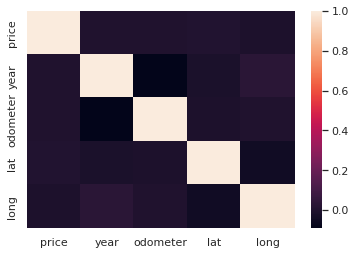

             price      year  odometer       lat      long
price     1.000000  0.436913 -0.395472  0.050241 -0.033861
year      0.436913  1.000000 -0.467597 -0.016569  0.003144
odometer -0.395472 -0.467597  1.000000  0.003699 -0.022900
lat       0.050241 -0.016569  0.003699  1.000000  0.081561
long     -0.033861  0.003144 -0.022900  0.081561  1.000000


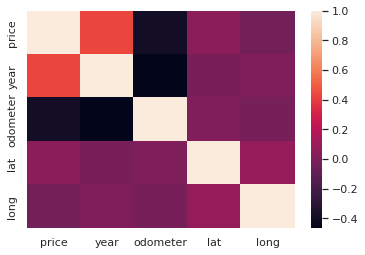

             price      year  odometer       lat      long
price     1.000000  0.331029 -0.281925  0.033970 -0.022568
year      0.331029  1.000000 -0.353447 -0.010615  0.001523
odometer -0.281925 -0.353447  1.000000  0.001990 -0.015516
lat       0.033970 -0.010615  0.001990  1.000000  0.059608
long     -0.022568  0.001523 -0.015516  0.059608  1.000000


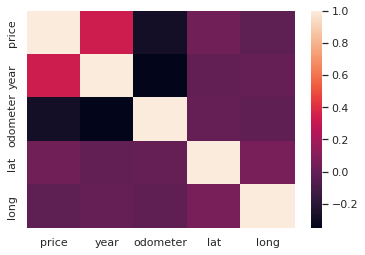

In [47]:
for elem in corr_list:
  sns.heatmap(elem)
  print(elem)
  plt.show()

The Pearson correlation coefficient shows us that there seems to be no apparent linear correlation between the features. After Standardizing the data (i.e. transforming features to have a mean of 0 and a standard deviation of 0) we could discover a linear correlation between features.
After using the Spearman and Kendall rank correlation coefficient we notice that there is indeed some kind of correlation between some of the features, just not a linear one.
None of these correlations turn out to be particurlarly strong, which is a problem for our modelling task, since none of the numeric features has the ability to discribe anotherone really well.
The biggest (negative) correlation with -0.46 (Spearman) is between 'odometer' and 'year'. This makes inuitively sense since older cars tend to be driven for longer than newer cars. This correlation would be classified as a weak to moderate correlation. Same with 'year' and 'price', as well as 'price' and 'odometer'. These make intuitively sense as well.

There doesn't seem to be a big difference between the dataset with and without imputed values. In future we'll use our imputed dataset.

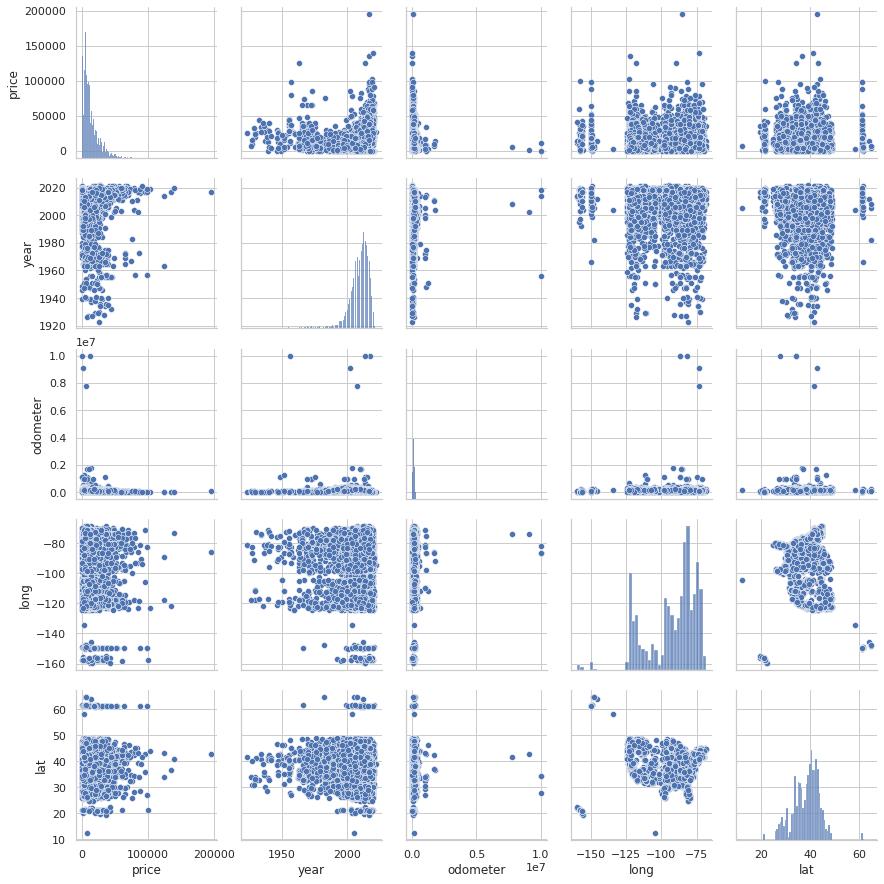

In [ ]:
sns.pairplot(df_impute[['price', 'year', 'odometer', 'long', 'lat']].sample(n=10000))

This pairplot illustrates it very well that there are unrealistic outlier values that heavily skew the distribution of the data (e.g. cell of 'year' and 'price'). 

Funny observation: The scatter plot of 'long' and 'lat' has the shape of the United States. Plotting the coordinates on a 2D plane shows basically the map where all car advertisments occured, which are scattered all over the US. The left points outside of the 'US mainland' probably belong to the state of Hawaii.


# Splitting & Saving data
**DISREGARD THIS PART**

From this point on we're going to work with the training dataset and reserve the test portion to validate our models in later stages.
This is done so our test data isn't touched by our data transformation as this would negate the point of test data. Test data should represent real-world data. For example, removing outliers on test data, would interfere with the nature of the distribution that would occur when deploying our models. Test data is there to measure real-world performance of these models.

# The Data

For this project we'll prepare 3 variants of this dataset, which will be realized with scipy pipelines:
1. Normalized, with outliers
2. Normalized, without outliers
3. Standardized, with outliers
4. Standardized, without outliers

These different sets serve to illustrate performance differences when applying certain pre-processing steps.

Also, Algorithms get affected differently by different data. For example, while density based clustering algorithms are robust to outliers and non-standardized data, algorithms like KNN are much more subsceptible to them.

### Functions and Pipeline

In [63]:
# Outlier handling with IQR (Interquartile Range Method)

#list_of_quantiles = [[]]  
def iqr_outlier(df, k=1.5, p_upper = 0.75, p_lower = 0.25): # outlier bound: k=1.5 for outliers, k=3 for extreme outliers

  quantiles = df.quantile([p_upper, p_lower]) # compute lower and upper quantile
  q_upper = quantiles.iloc[0]
  q_lower = quantiles.iloc[1]

  iqr = quantiles.iloc[0]-quantiles.iloc[1] # define Interquartile Range
  iqr
  q_upper
  cut_off = iqr * k  # bound for outlier

  lower, upper = q_lower-cut_off, q_upper+cut_off

  # # remove lower outlier
  for col in lower.index:
    df = df[df[col] >= lower.loc[col]]
    print("{}\t{}".format(col, df.shape))

  # # remove upper outlier
  for col in lower.index:
    df = df[df[col] <= upper.loc[col]]
    print("{}\t{}".format(col, df.shape))
  print()
  print(df.shape)
  return df

To get a better understanding of the IQR method: **Data Preparation for
Machine Learning** by Jason Brownlee  

In [64]:
# Pipeline
transformer = Pipeline(steps=[
    ('normalizer', MinMaxScaler()),
    ('standarizer', RobustScaler())
    #('standarizer', StandardScaler())
    ])

### 1. Dataset
Normalized, with outliers

In [65]:
df_norm = df_impute.copy()
df_norm[['price', 'year', 'odometer', 'lat', 'long']] = transformer['normalizer'].fit_transform(df_norm[['price', 'year', 'odometer', 'lat', 'long']])
df_norm

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
31,auburn,0.000004,0.926230,ford,f-150 xlt,excellent,6 cylinders,gas,0.012800,clean,automatic,rwd,full-size,truck,black,al,0.697358,0.247823
55,auburn,0.000005,0.852459,ford,f250 super duty,good,8 cylinders,diesel,0.008800,clean,automatic,4wd,full-size,pickup,blue,al,0.697087,0.247992
59,auburn,0.000004,0.918033,honda,odyssey,excellent,6 cylinders,gas,0.009500,clean,automatic,fwd,full-size,mini-van,silver,al,0.697582,0.248013
65,auburn,0.000006,0.827869,ford,f450,good,8 cylinders,diesel,0.014470,clean,manual,rwd,full-size,truck,white,al,0.697592,0.248214
73,auburn,0.000004,0.959016,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,0.009000,rebuilt,automatic,rwd,mid-size,sedan,grey,al,0.698762,0.246983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,wyoming,0.000005,0.860656,chevrolet,silverado 1500 lt 4x4,excellent,8 cylinders,gas,0.013000,lien,automatic,4wd,full-size,truck,blue,wy,0.763546,0.163590
426809,wyoming,0.000005,0.737705,jeep,gand wagoneer,good,8 cylinders,gas,0.011440,clean,automatic,4wd,full-size,SUV,black,wy,0.763546,0.163590
426831,wyoming,0.000003,0.696721,nissan,300zx coupe with t-tops,like new,6 cylinders,gas,0.011500,clean,automatic,rwd,sub-compact,hatchback,red,wy,0.749474,0.183439
426833,wyoming,0.000002,0.795082,jaguar,xk8 convertible,good,8 cylinders,gas,0.006955,clean,automatic,rwd,compact,convertible,white,wy,0.764704,0.171994


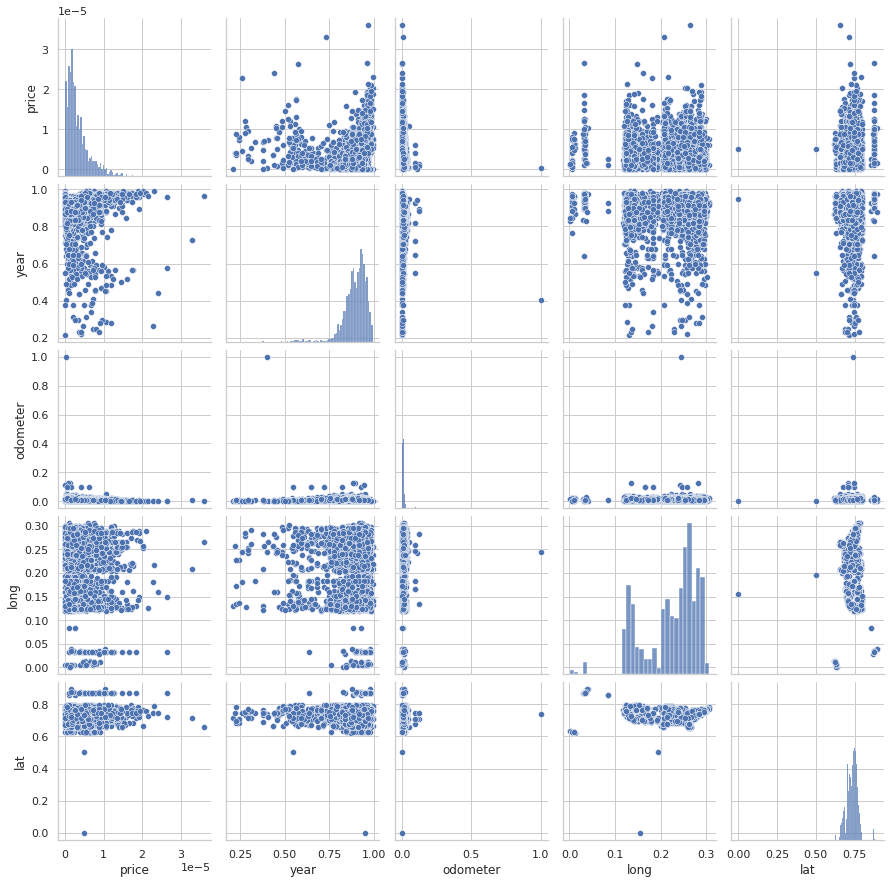

In [66]:
sns.pairplot(df_norm[['price', 'year', 'odometer', 'long', 'lat']].sample(n=5000, random_state=3))

### 2. Dataset
Normalized, without outliers

In [67]:
# Removing outlier
df_norm_no_outlier = df_norm.copy()
df_norm_no_outlier = iqr_outlier(df=df_norm_no_outlier, k=3)

price	(79614, 18)
year	(77391, 18)
odometer	(77391, 18)
lat	(77380, 18)
long	(77380, 18)
price	(76623, 18)
year	(76623, 18)
odometer	(76395, 18)
lat	(76369, 18)
long	(76359, 18)

(76359, 18)


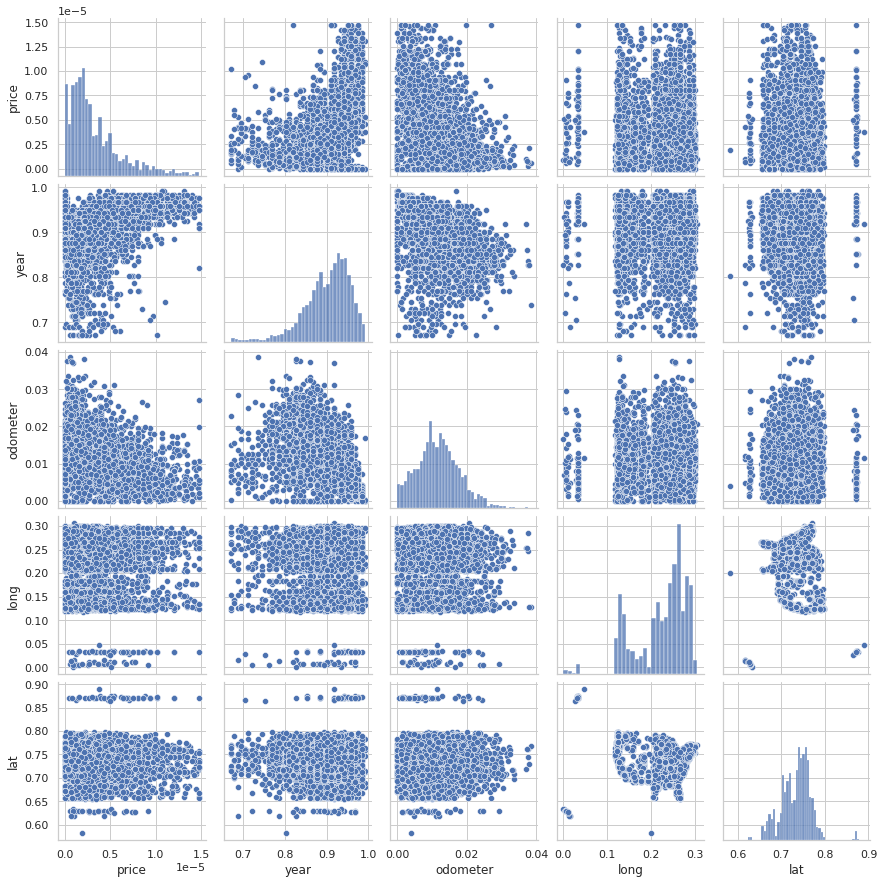

In [68]:
sns.pairplot(df_norm_no_outlier[['price', 'year', 'odometer', 'long', 'lat']].sample(n=5000, random_state=3))

### 3. Dataset
Standardized, with outliers

In [69]:
df_std = df_impute.copy()
df_std[['price', 'year', 'odometer', 'lat', 'long']] = transformer.fit_transform(df_std[['price', 'year', 'odometer', 'lat', 'long']])
df_std

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
31,auburn,0.478088,0.250,ford,f-150 xlt,excellent,6 cylinders,gas,0.168580,clean,automatic,rwd,full-size,truck,black,al,-0.918215,0.045869
55,auburn,0.868526,-0.875,ford,f250 super duty,good,8 cylinders,diesel,-0.320661,clean,automatic,4wd,full-size,pickup,blue,al,-0.924292,0.047910
59,auburn,0.398406,0.125,honda,odyssey,excellent,6 cylinders,gas,-0.235044,clean,automatic,fwd,full-size,mini-van,silver,al,-0.913198,0.048167
65,auburn,1.075697,-1.250,ford,f450,good,8 cylinders,diesel,0.372839,clean,manual,rwd,full-size,truck,white,al,-0.912971,0.050591
73,auburn,0.478088,0.750,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,-0.296199,rebuilt,automatic,rwd,mid-size,sedan,grey,al,-0.886749,0.035744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,wyoming,0.717131,-0.750,chevrolet,silverado 1500 lt 4x4,excellent,8 cylinders,gas,0.193042,lien,automatic,4wd,full-size,truck,blue,wy,0.565067,-0.969454
426809,wyoming,0.717131,-2.625,jeep,gand wagoneer,good,8 cylinders,gas,0.002238,clean,automatic,4wd,full-size,SUV,black,wy,0.565067,-0.969454
426831,wyoming,0.063745,-3.250,nissan,300zx coupe with t-tops,like new,6 cylinders,gas,0.009577,clean,automatic,rwd,sub-compact,hatchback,red,wy,0.249708,-0.730197
426833,wyoming,-0.175299,-1.750,jaguar,xk8 convertible,good,8 cylinders,gas,-0.546324,clean,automatic,rwd,compact,convertible,white,wy,0.591033,-0.868152


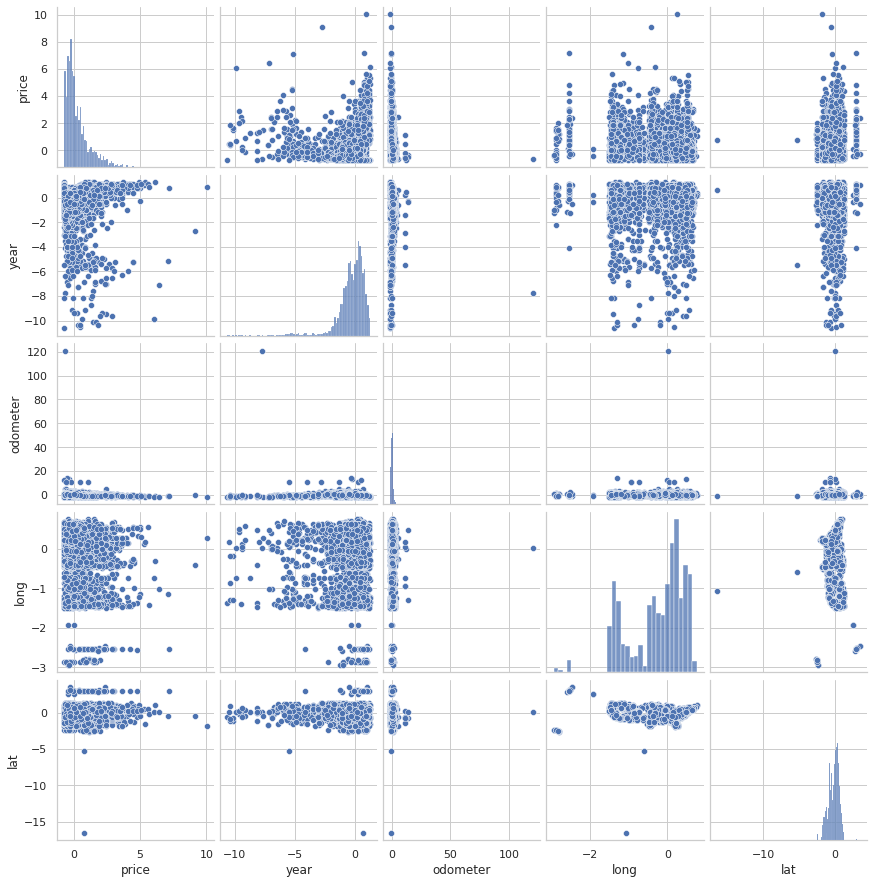

In [70]:
sns.pairplot(df_std[['price', 'year', 'odometer', 'long', 'lat']].sample(n=5000, random_state=3))

### 4. Dataset
Standardized, without outliers

In [71]:
df_std_no_outlier = df_norm_no_outlier.copy()
df_std_no_outlier[['price', 'year', 'odometer', 'lat', 'long']] = transformer.fit_transform(df_std_no_outlier[['price', 'year', 'odometer', 'lat', 'long']])
df_std_no_outlier

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
31,auburn,0.496486,0.250,ford,f-150 xlt,excellent,6 cylinders,gas,0.144076,clean,automatic,rwd,full-size,truck,black,al,-0.922731,0.045145
55,auburn,0.901612,-0.875,ford,f250 super duty,good,8 cylinders,diesel,-0.358368,clean,automatic,4wd,full-size,pickup,blue,al,-0.928838,0.047197
59,auburn,0.413807,0.125,honda,odyssey,excellent,6 cylinders,gas,-0.270440,clean,automatic,fwd,full-size,mini-van,silver,al,-0.917689,0.047455
65,auburn,1.116577,-1.250,ford,f450,good,8 cylinders,diesel,0.353846,clean,manual,rwd,full-size,truck,white,al,-0.917461,0.049892
73,auburn,0.496486,0.750,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,-0.333245,rebuilt,automatic,rwd,mid-size,sedan,grey,al,-0.891110,0.034968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,wyoming,0.744523,-0.750,chevrolet,silverado 1500 lt 4x4,excellent,8 cylinders,gas,0.169198,lien,automatic,4wd,full-size,truck,blue,wy,0.567846,-0.975480
426809,wyoming,0.744523,-2.625,jeep,gand wagoneer,good,8 cylinders,gas,-0.026755,clean,automatic,4wd,full-size,SUV,black,wy,0.567846,-0.975480
426831,wyoming,0.066556,-3.250,nissan,300zx coupe with t-tops,like new,6 cylinders,gas,-0.019218,clean,automatic,rwd,sub-compact,hatchback,red,wy,0.250936,-0.734973
426833,wyoming,-0.181480,-1.750,jaguar,xk8 convertible,good,8 cylinders,gas,-0.590119,clean,automatic,rwd,compact,convertible,white,wy,0.593940,-0.873648


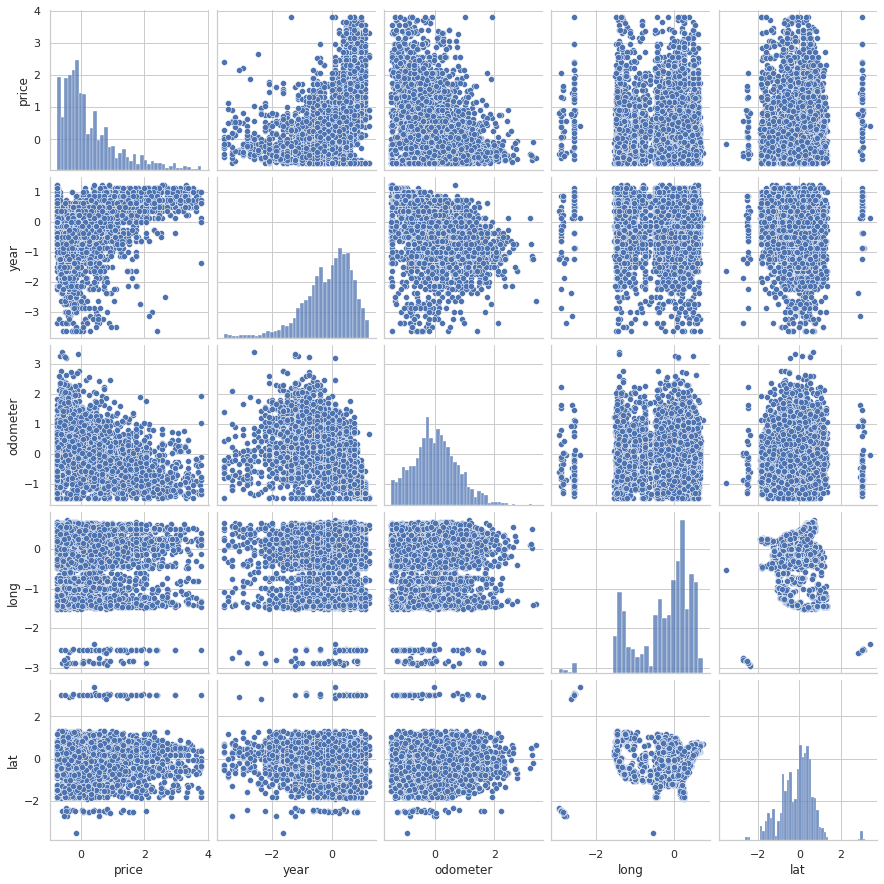

In [72]:
sns.pairplot(df_std_no_outlier[['price', 'year', 'odometer', 'long', 'lat']].sample(n=5000, random_state=3))

In [73]:
# test
std_test = df_norm_no_outlier.copy()
scaler = StandardScaler()
std_test[['price', 'year', 'odometer', 'long', 'lat']] = scaler.fit_transform(std_test[['price', 'year', 'odometer', 'long', 'lat']])
std_test

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
31,auburn,0.236531,0.512828,ford,f-150 xlt,excellent,6 cylinders,gas,0.154123,clean,automatic,rwd,full-size,truck,black,al,-1.049460,0.404646
55,auburn,0.688427,-0.878685,ford,f250 super duty,good,8 cylinders,diesel,-0.508642,clean,automatic,4wd,full-size,pickup,blue,al,-1.057465,0.407560
59,auburn,0.144307,0.358216,honda,odyssey,excellent,6 cylinders,gas,-0.392658,clean,automatic,fwd,full-size,mini-van,silver,al,-1.042851,0.407927
65,auburn,0.928208,-1.342523,ford,f450,good,8 cylinders,diesel,0.430827,clean,manual,rwd,full-size,truck,white,al,-1.042552,0.411388
73,auburn,0.236531,1.131279,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,-0.475504,rebuilt,automatic,rwd,mid-size,sedan,grey,al,-1.008013,0.390192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,wyoming,0.513202,-0.724073,chevrolet,silverado 1500 lt 4x4,excellent,8 cylinders,gas,0.187261,lien,automatic,4wd,full-size,truck,blue,wy,0.904299,-1.044837
426809,wyoming,0.513202,-3.043262,jeep,gand wagoneer,good,8 cylinders,gas,-0.071217,clean,automatic,4wd,full-size,SUV,black,wy,0.904299,-1.044837
426831,wyoming,-0.243032,-3.816325,nissan,300zx coupe with t-tops,like new,6 cylinders,gas,-0.061276,clean,automatic,rwd,sub-compact,hatchback,red,wy,0.488913,-0.703271
426833,wyoming,-0.519703,-1.960974,jaguar,xk8 convertible,good,8 cylinders,gas,-0.814342,clean,automatic,rwd,compact,convertible,white,wy,0.938502,-0.900217


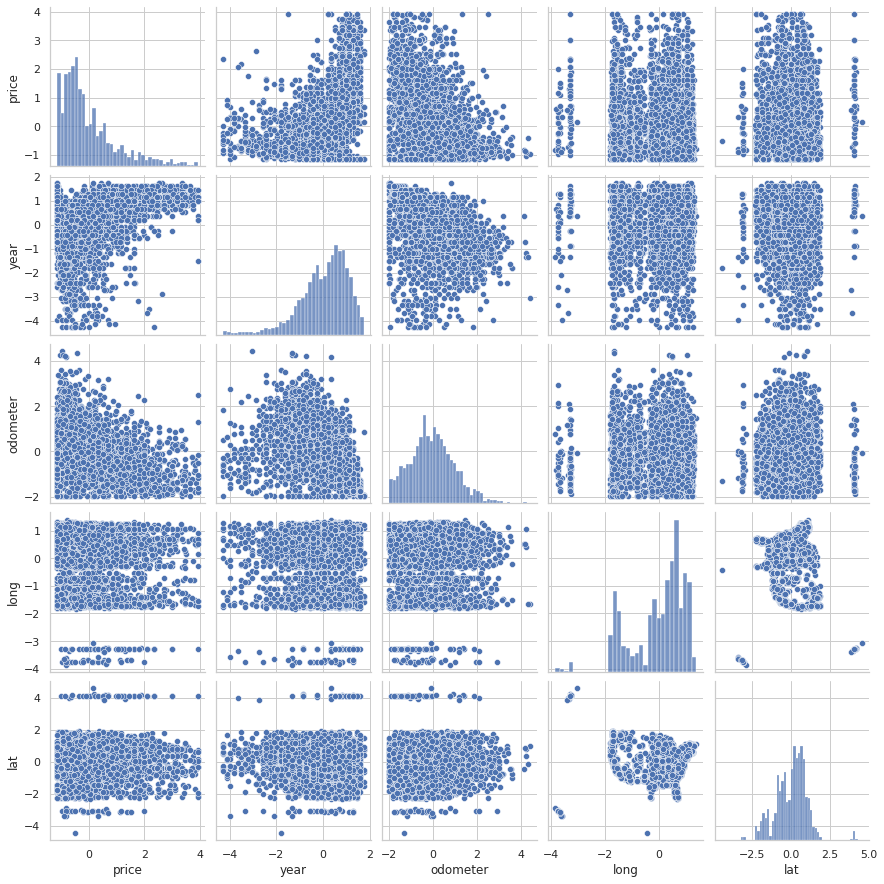

In [74]:
sns.pairplot(std_test[['price', 'year', 'odometer', 'long', 'lat']].sample(n=5000, random_state=3))

# A look at the transformed data

In [48]:
# select dataframe
df_corr = df_corr = df_std_no_outlier

corr_pearson = df_corr.corr(method='pearson')
corr_spearman = df_corr.corr(method='spearman')
corr_kendall = df_corr.corr(method='kendall')
corr_list = [corr_pearson, corr_spearman, corr_kendall]

             price      year  odometer       lat      long
price     1.000000  0.420867 -0.378643  0.042352 -0.036745
year      0.420867  1.000000 -0.448441 -0.017656  0.018076
odometer -0.378643 -0.448441  1.000000  0.013069 -0.014222
lat       0.042352 -0.017656  0.013069  1.000000 -0.035433
long     -0.036745  0.018076 -0.014222 -0.035433  1.000000


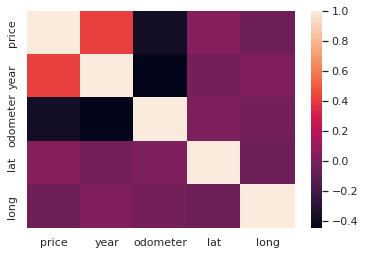

             price      year  odometer       lat      long
price     1.000000  0.468943 -0.382185  0.052560 -0.033648
year      0.468943  1.000000 -0.538336 -0.018028 -0.002084
odometer -0.382185 -0.538336  1.000000  0.004820 -0.031795
lat       0.052560 -0.018028  0.004820  1.000000  0.086181
long     -0.033648 -0.002084 -0.031795  0.086181  1.000000


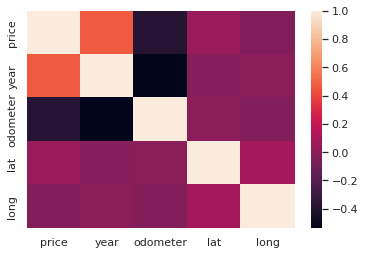

             price      year  odometer       lat      long
price     1.000000  0.354181 -0.272295  0.035549 -0.022433
year      0.354181  1.000000 -0.400490 -0.011567 -0.001965
odometer -0.272295 -0.400490  1.000000  0.002754 -0.021412
lat       0.035549 -0.011567  0.002754  1.000000  0.062777
long     -0.022433 -0.001965 -0.021412  0.062777  1.000000


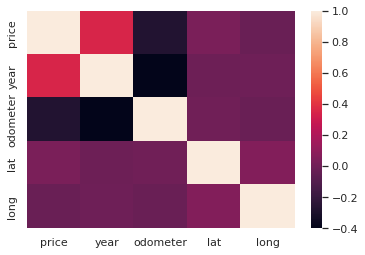

In [49]:
for elem in corr_list:
  sns.heatmap(elem)
  print(elem)
  plt.show()

After data transformation we can now see linear correlation (Pearson) that wasn't visible before! Also the Spearman correlation coefficients improved a bit.

E.g. Odometer - Year: -0.46 --> -0.54 from (weak-moderate --> moderate)

# Save data



In [75]:
df_norm.to_pickle('df_norm')
df_norm_no_outlier.to_pickle('df_norm_no_outlier')
df_std.to_pickle('df_std')
df_std_no_outlier.to_pickle('df_std_no_outlier')